# Optimization of a Dissipative State-to-State Transfer in a Lambda System

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import qutip
from qutip import Qobj
import pickle
from functools import partial
%watermark -v --iversions

Python implementation: CPython
Python version       : 3.12.0
IPython version      : 8.25.0

numpy     : 1.26.4
matplotlib: 3.7.5
qutip     : 4.7.6
scipy     : 1.12.0
krotov    : 1.3.0+dev



$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{ketbra}[2]{\vert#1\rangle\!\langle#2\vert}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
\newcommand{toP}[0]{\omega_{12}}
\newcommand{toS}[0]{\omega_{23}}$

This example illustrates the use of Krotov's method with a non-Hermitian
Hamiltonian. It considers the same system as the [previous
example](02_example_lambda_system_rwa_complex_pulse.ipynb), a transition
$\ket{1} \rightarrow \ket{3}$ in a three-level system in a
$\Lambda$-configuration. However, here we add a non-Hermitian decay term to
model loss from the intermediary level $\ket{2}$. At a technical level, this
examples also illustrates how to use `args` in time-dependent control fields
("QuTiP style"), as opposed to hard-coding parameters or setting them through
a closure, as was done in the previous examples.

## The effective Hamiltonian

We consider the system as in the following diagram:

![Lambda system considered in this notebook](energylevels.png)

with the Hamiltonian

$$
\Op{H}_{\text{lab}} = \begin{pmatrix}
    E_1                     & -\mu_{12} \epsilon_P(t) & 0                          \\
    -\mu_{12} \epsilon_P(t) & E_2                     & - \mu_{23} \epsilon_S(t) \\
    0                       & -\mu_{23} \epsilon_S(t) &  E_2
\end{pmatrix}
$$

in the lab frame.

However, we now also include that the level $\ket{2}$ decays incoherently. This
is the primary motivation of the STIRAP scheme: through destructive
interference it can keep the dynamics in a "dark state" where the population is
transferred from $\ket{1}$ to $\ket{3}$ without ever populating the $\ket{2}$
state. A rigorous treatment would be to include the dissipation as a Lindblad
operator, and to simulate the dynamics and perform the optimization in
Liouville space. The Lindblad operator for spontaneous decay from level
$\ket{2}$ with decay rate $2\gamma$ is $\Op{L} = \sqrt{2\gamma} \ketbra{1}{2}$.
However, this is numerically expensive. For the optimization,
it is sufficient to find a way to penalize population in the $\ket{2}$ state.

Motivated by the [Monte-Carlo Wave Function
(MCWF)](https://en.wikipedia.org/wiki/Quantum_jump_method) method, we define
the non-Hermitian *effective Hamiltonian*

$$
\Op{H}_{\text{eff}} = \Op{H}_{\text{lab}} - \frac{i}{2} \Op{L}^{\dagger} \Op{L}
$$

In explicit form, this is

$$
\Op{H}_{\text{eff}} = \begin{pmatrix}
    E_1                     & -\mu_{12} \epsilon_P(t) & 0                          \\
    -\mu_{12} \epsilon_P(t) & E_2 - i \gamma          & - \mu_{23} \epsilon_S(t)   \\
    0                       & -\mu_{23} \epsilon_S(t) &  E_2
\end{pmatrix}
$$

The only change is that the energy of level $\ket{2}$ now has an imaginary part
$-\gamma$, which causes an exponential decay of any population amplitude in
$\ket{2}$, and thus a decay in the norm of the state. In the MCWF, this decay
of the norm is used to track the probability that quantum jump occurs
(otherwise, the state is re-normalized). Here, we do not perform quantum jumps
or renormalize the state. Instead, we use the decay in the norm to steer the
optimization. Using the functional

$$
J_{T, \text{re}} = 1 - \Re{\Braket{\Psi(T)}{\Psi^{\tgt}}}
$$

to be minimized, we find that the value of
the functional increases if $\Norm{\ket{\Psi(T)}} < 1$. Thus, population in
$\ket{2}$ is penalized, without any significant numerical overhead.

The decay rate $2\gamma$ does not necessarily need to correspond to the actual
physical lifetime of the $\ket{2}$ state: we can choose an artificially high
decay rate to put a stronger penalty on the $\ket{2}$ level. Or, if the
physical decay is so strong that the norm of the state reaches effectively
zero, we could decrease $\gamma$ to avoid numerical instability. The use of a
non-Hermitian Hamiltonian with artificial decay is generally a useful trick to
penalize population in a subspace.

The new non-Hermitian decay term remains unchanged when we make the rotating
wave approximation. The RWA Hamiltonian now reads

$$
\Op{H}_{\text{RWA}} = \begin{pmatrix}
    \Delta_P                    & -\frac{1}{2} \Omega_P(t)   & 0                          \\
    -\frac{1}{2} \Omega_P^*(t)  & -i \gamma                  &  -\frac{1}{2} \Omega_S(t)  \\
    0                           & -\frac{1}{2} \Omega_S^*(t) & \Delta_S
\end{pmatrix}\,,
$$

with complex control fields $\Omega_P(t)$ and $\Omega_S(t)$, see the [previous
example](02_example_lambda_system_rwa_complex_pulse.ipynb). Again, we split
these complex pulses into an independent real and imaginary part for the
purpose of optimization.

The guess controls are

In [2]:
def Omega_P1(t, args):
    """Guess for the real part of the pump pulse.

    Blackman shape with amplitude `Ω0` from `t0P` to `t0P` + `ΔTP`, with
    parameters from `args`.
    """
    t0 = args['t0P']
    T = t0 + args['ΔTP']
    return args['Ω0'] * krotov.shapes.blackman(t, t_start=t0, t_stop=T)


def Omega_P2(t, args):
    """Guess for the imaginary part of the pump pulse (zero)."""
    return 0.0


def Omega_S1(t, args):
    """Guess for the real part of the Stokes pulse.

    Blackman shape with amplitude `Ω0` from `t0S` to `t0S` + `ΔTS`, with
    parameters from `args`.
    """
    t0 = args['t0S']
    T = t0 + args['ΔTS']
    return args['Ω0'] * krotov.shapes.blackman(t, t_start=t0, t_stop=T)


def Omega_S2(t, args):
    """Guess for the imaginary part of the Stokes pulse (zero)."""
    return 0.0

with the Hamiltonian defined as

In [3]:
def hamiltonian(args):
    """Lambda-system Hamiltonian in the RWA"""
    E1, E2, E3, ΩP, ΩS, γ = (args[key] for key in 'E1 E2 E3 ΩP ΩS γ'.split())

    # detunings
    ΔP = E1 + ΩP - E2
    ΔS = E3 + ΩS - E2

    H0 = Qobj([[ΔP, 0.0, 0.0], [0.0, -1j * γ, 0.0], [0.0, 0.0, ΔS]])

    HP_re = -0.5 * Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
    HP_im = -0.5 * Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])

    HS_re = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
    HS_im = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])

    return [
        H0,
        [HP_re, Omega_P1],
        [HP_im, Omega_P2],
        [HS_re, Omega_S1],
        [HS_im, Omega_S2],
    ]

and using the following physical parameters:

In [4]:
ARGS = dict(
    Ω0=5.0,  # amplitude of both the Pump and the Stokes laser
    ΔTP=3.0,  # duration of the Pump laser
    ΔTS=3.0,  # duration of the Stokes laser
    t0P=2.0,  # starting time for the Pump laser
    t0S=0.0,  # starting time for the Stokes laser
    t_rise=0.3,  # switch-on/-off time in update shape
    E1=0.0,  # energy of level |1⟩
    E2=10.0,  # energy of intermediary level |2⟩
    E3=5.0,  # energy of target level |3⟩
    ΩP=9.5,  # frequency of the Pump laser
    ΩS=4.5,  # frequency of the Stokes laser
    γ=0.5,  # decay rate on intermediary level |2⟩
    T=5.0,  # total process time
)

(cf. the [previous example](02_example_lambda_system_rwa_complex_pulse.ipynb),
where these values were hard-coded).

The Hamiltonian is now instantiated as

In [5]:
H = hamiltonian(ARGS)

We check the hermiticity of the Hamiltonian:

In [6]:
print("H0 is Hermitian: " + str(H[0].isherm))
print("H1 is Hermitian: "+ str(
        H[1][0].isherm
    and H[2][0].isherm
    and H[3][0].isherm
    and H[4][0].isherm))

H0 is Hermitian: False
H1 is Hermitian: True


## Define the optimization target

We optimize for the phase-sensitive transition $\ket{1} \rightarrow \ket{3}$.
As we are working in the rotating frame, the target state must be adjusted with
an appropriate phase factor:

In [7]:
ket1 = qutip.Qobj(np.array([1.0, 0.0, 0.0]))
ket2 = qutip.Qobj(np.array([0.0, 1.0, 0.0]))
ket3 = qutip.Qobj(np.array([0.0, 0.0, 1.0]))

def rwa_target_state(ket3, *, E2, ΩS, T):
    return np.exp(1j * (E2 - ΩS) * T) * ket3

psi_target = rwa_target_state(ket3, **{k: ARGS[k] for k in 'E2 ΩS T'.split()})

The objective is now instantiated as

In [8]:
objectives = [krotov.Objective(initial_state=ket1, target=psi_target, H=H)]
objectives

[Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [A₀[3,3], [H₁[3,3], u₁(t)], [H₂[3,3], u₂(t)], [H₃[3,3], u₃(t)], [H₄[3,3], u₄(t)]]]]

## Simulate dynamics under the guess field

We use a time grid with 500 steps between $t=0$ and $T=5$:

In [9]:
tlist = np.linspace(0, ARGS['T'], 500)

We propagate once for the population dynamics, and once to obtain the
propagated states for each point on the time grid:

In [10]:
proj1 = qutip.ket2dm(ket1)
proj2 = qutip.ket2dm(ket2)
proj3 = qutip.ket2dm(ket3)

guess_dynamics = objectives[0].propagate(
    tlist,
    propagator=krotov.propagators.expm,
    e_ops=[proj1, proj2, proj3],
    args=ARGS,
)
guess_states = objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm, args=ARGS,
)

In [11]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.axhline(y=1.0, color='black', lw=0.5, ls='dashed')
    ax.axhline(y=0.0, color='black', lw=0.5, ls='dashed')
    ax.plot(result.times, result.expect[0], label='1')
    ax.plot(result.times, result.expect[1], label='2')
    ax.plot(result.times, result.expect[2], label='3')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)


def plot_norm(result):

    state_norm = lambda i: result.states[i].norm()
    states_norm=np.vectorize(state_norm)

    fig, ax = plt.subplots()
    ax.plot(result.times, states_norm(np.arange(len(result.states))))
    ax.set_xlabel('time')
    ax.set_ylabel('state norm')
    plt.show(fig)

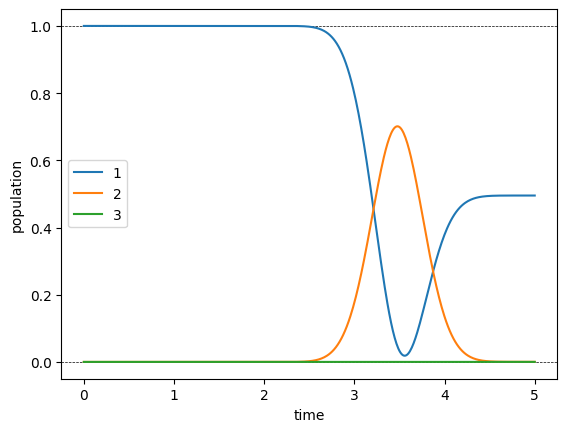

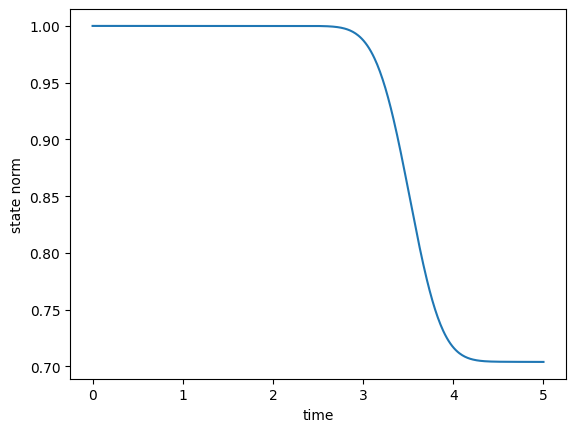

In [12]:
plot_population(guess_dynamics)
plot_norm(guess_states)

The population dynamics and the norm-plot show the effect the non-Hermitian
term in the Hamiltonian, resulting in a 30% loss.

## Optimize

For each control, we define the update shape and the $\lambda_a$ parameter that
determines the magnitude of the update:

In [13]:
S = partial(  # Scale the *update* of the pulse value at time t
    krotov.shapes.flattop,
    t_start=0.0,
    t_stop=ARGS['T'],
    t_rise=ARGS['t_rise'],
    func='sinsq',
)

In [14]:
pulse_options = {
    H[1][1]: dict(lambda_a=2.0, update_shape=S, args=ARGS),
    H[2][1]: dict(lambda_a=2.0, update_shape=S, args=ARGS),
    H[3][1]: dict(lambda_a=2.0, update_shape=S, args=ARGS),
    H[4][1]: dict(lambda_a=2.0, update_shape=S, args=ARGS)
}

The `args` here are required to plug in in the parameters in the guess
`Omega_P1` and `Omega_S1`. Compare this to the [previous
example](02_example_lambda_system_rwa_complex_pulse.ipynb), where the
parameters were hardcoded in the definition of the guess controls.

We now run the optimization for 40 iterations, printing out the fidelity

$$
F_{\text{re}} = \Re{\Braket{\Psi(T)}{\Psi^{\tgt}}}
$$

after each iteration.

In [15]:
def print_fidelity(**kwargs):
    F_re = np.average(np.array(kwargs['tau_vals']).real)
    print("   F = %f" % F_re)
    return F_re

In [16]:
opt_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity,
    iter_stop=40
)

   F = -0.007819


   F = 0.055166


   F = 0.117611


   F = 0.178915


   F = 0.238526


   F = 0.295951


   F = 0.350777


   F = 0.402680


   F = 0.451424


   F = 0.496859


   F = 0.538920


   F = 0.577612


   F = 0.613000


   F = 0.645200


   F = 0.674362


   F = 0.700665


   F = 0.724303


   F = 0.745478


   F = 0.764395


   F = 0.781255


   F = 0.796250


   F = 0.809566


   F = 0.821372


   F = 0.831829


   F = 0.841083


   F = 0.849267


   F = 0.856501


   F = 0.862895


   F = 0.868544


   F = 0.873538


   F = 0.877952


   F = 0.881855


   F = 0.885310


   F = 0.888369


   F = 0.891080


   F = 0.893485


   F = 0.895622


   F = 0.897522


   F = 0.899214


   F = 0.900724


   F = 0.902073


We look at the optimized controls and the population dynamics they induce:

pump pulse amplitude and phase:


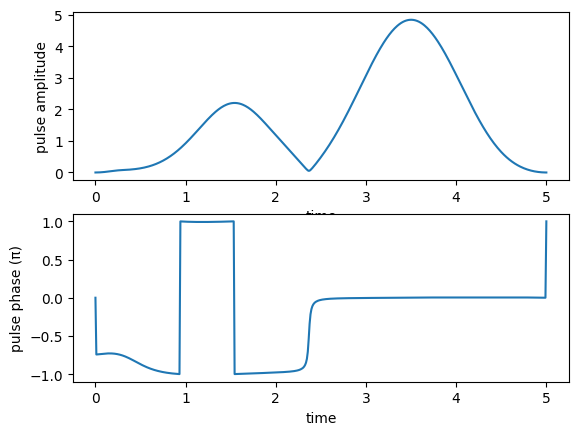

Stokes pulse amplitude and phase:


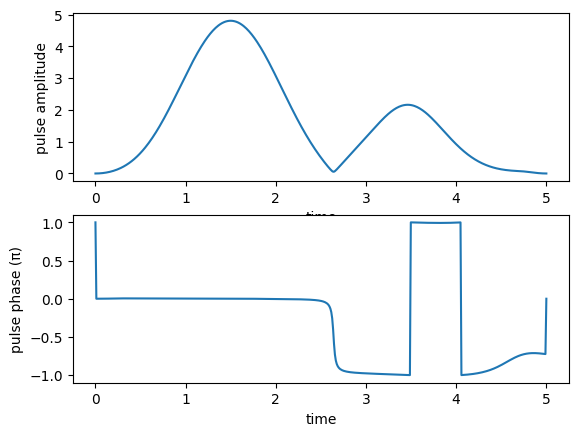

In [17]:
def plot_pulse_amplitude_and_phase(pulse_real, pulse_imaginary,tlist):
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    amplitudes = [np.sqrt(x*x + y*y) for x,y in zip(pulse_real,pulse_imaginary)]
    phases = [np.arctan2(y,x)/np.pi for x,y in zip(pulse_real,pulse_imaginary)]
    ax1.plot(tlist,amplitudes)
    ax1.set_xlabel('time')
    ax1.set_ylabel('pulse amplitude')
    ax2.plot(tlist,phases)
    ax2.set_xlabel('time')
    ax2.set_ylabel('pulse phase (π)')
    plt.show()

print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist)

We check the evolution of the population due to our optimized pulses.

In [18]:
opt_dynamics = opt_result.optimized_objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm, e_ops=[proj1, proj2, proj3])
opt_states = opt_result.optimized_objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm)

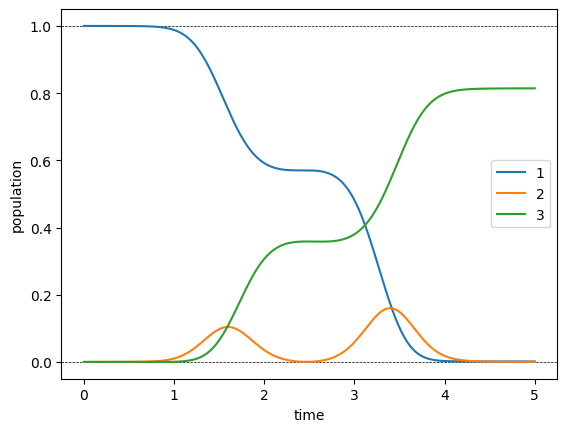

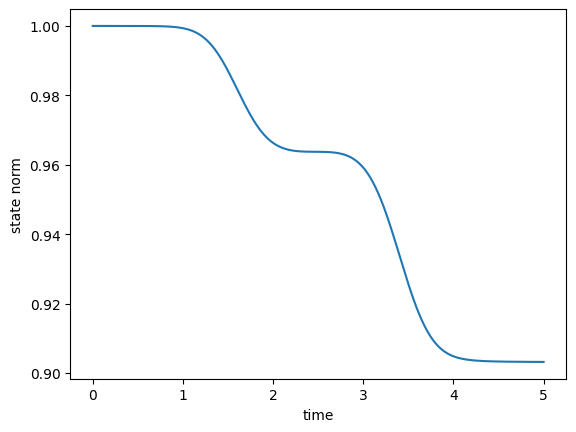

In [19]:
plot_population(opt_dynamics)
plot_norm(opt_states)

These dynamics show that the non-Hermitian Hamiltonian has the desired effect:
The population is steered out of the decaying $\ket{2}$ state, with the
resulting loss in norm down to 10% from the 30% loss of the guess pulses.
Indeed, these 10% are exactly the value of the error $1 - F_{\text{re}}$,
indicating that avoiding population in the $\ket{2}$ part is the difficult part
of the optimization. Convergence towards this goal is slow, so we continue the
optimization up to iteration 2000.

In [20]:
dumpfile = "./non_herm_opt_result.dump"
if os.path.isfile(dumpfile):
    opt_result = krotov.result.Result.load(dumpfile, objectives)
else:
    opt_result = krotov.optimize_pulses(
        objectives, pulse_options, tlist,
        propagator=krotov.propagators.expm,
        chi_constructor=krotov.functionals.chis_re,
        info_hook=krotov.info_hooks.chain(print_fidelity),
        iter_stop=2000,
        continue_from=opt_result
    )
    opt_result.dump(dumpfile)

In [21]:
print("Final fidelity: %.3f" % opt_result.info_vals[-1])

Final fidelity: 0.966


In [22]:
def plot_convergence(result):
    fig, ax = plt.subplots()
    ax.semilogy(result.iters, 1-np.array(result.info_vals))
    ax.set_xlabel('OCT iteration')
    ax.set_ylabel('error')
    plt.show(fig)

To get a feel for the convergence, we can plot the optimization error over the iteration number:

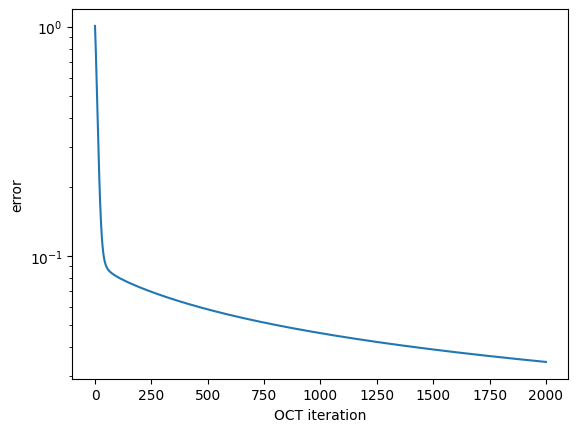

In [23]:
plot_convergence(opt_result)

We have used here that the return value of the routine `print_fidelity` that was passed to the `optimize_pulses` routine as an `info_hook` is automatically accumulated in `result.info_vals`.

We also look at optimized controls and the dynamics they induce:

pump pulse amplitude and phase:


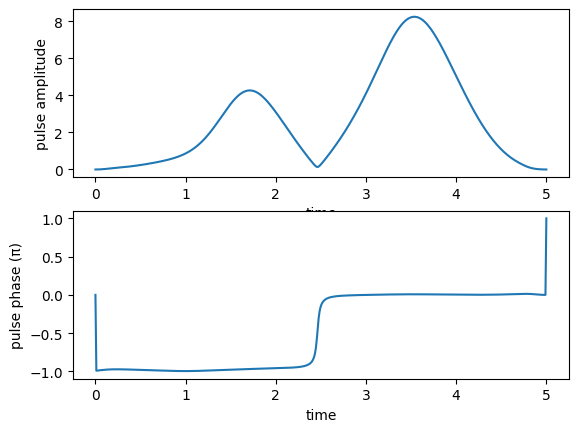

Stokes pulse amplitude and phase:


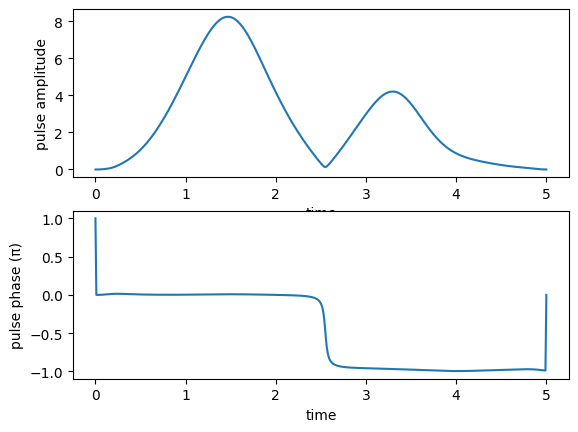

In [24]:
print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist)

In [25]:
opt_dynamics = opt_result.optimized_objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm, e_ops=[proj1, proj2, proj3])
opt_states = opt_result.optimized_objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm)

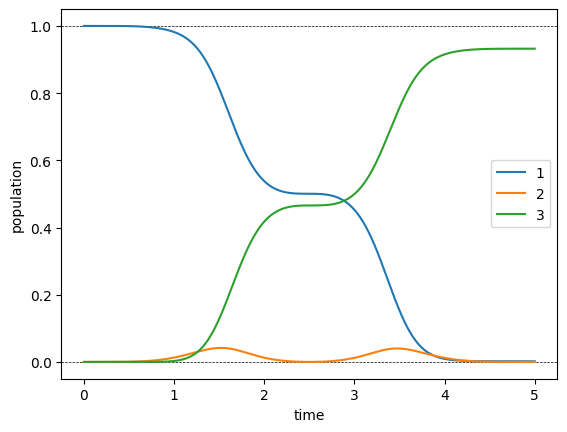

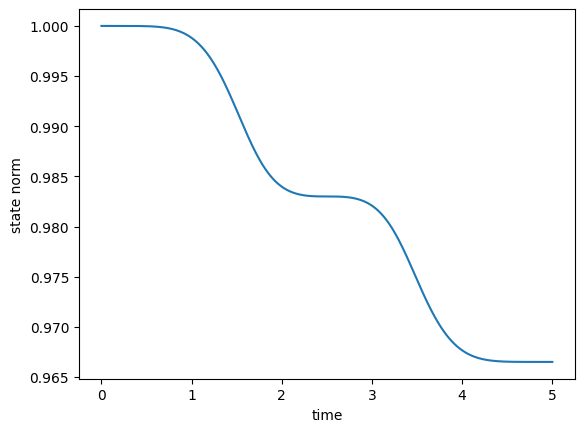

In [26]:
plot_population(opt_dynamics)
plot_norm(opt_states)

In accordance with the lower optimization error, the population dynamics now show
a reasonably efficient transfer, and a significantly reduced population in
state $\ket{2}$.

Finally, we can convert the complex-valued $\Omega_P$ and $\Omega_S$ functions to the
physical electric fields $\epsilon_{P}$ and $\epsilon_{S}$:

Physical electric pump pulse in the lab frame:


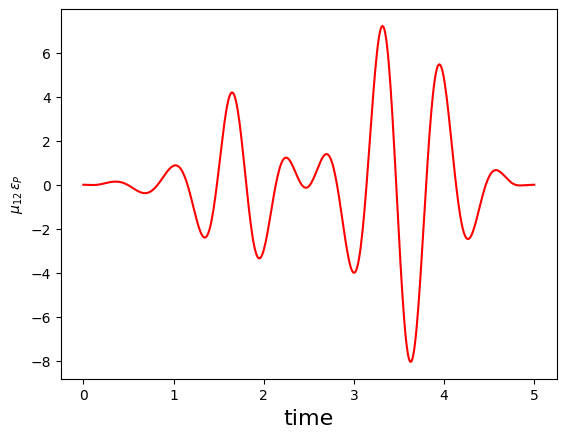

Physical electric Stokes pulse in the lab frame:


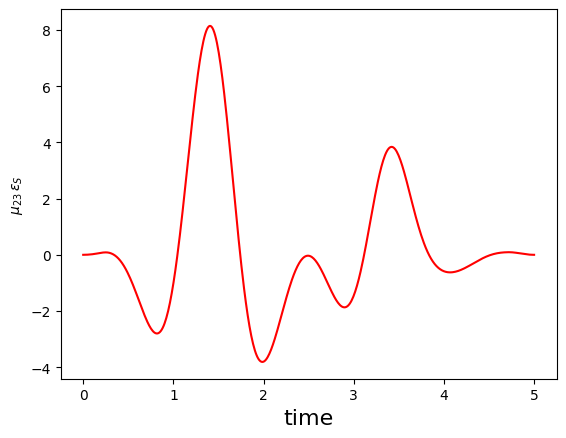

In [27]:
def plot_physical_field(pulse_re, pulse_im, tlist, case=None):

    if case == 'pump':
        w = 9.5
    elif case == 'stokes':
        w = 4.5
    else:
        print('Error: selected case is not a valid option')
        return

    ax = plt.subplot(111)
    ax.plot(tlist,pulse_re*np.cos(w*tlist)-pulse_im*np.sin(w*tlist), 'r')
    ax.set_xlabel('time', fontsize = 16)
    if case == 'pump':
        ax.set_ylabel(r'$\mu_{12}\,\epsilon_{P}$')
    elif case == 'stokes':
        ax.set_ylabel(r'$ \mu_{23}\,\epsilon_{S}$')
    plt.show()


print('Physical electric pump pulse in the lab frame:')
plot_physical_field(
    opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist, case = 'pump')


print('Physical electric Stokes pulse in the lab frame:')
plot_physical_field(
    opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist, case = 'stokes')